In [22]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin

import warnings
warnings.filterwarnings('ignore')

drive_path = '/content/drive/MyDrive/Kuliah/Tugas Akhir/Final Project Shared Folder'
data_path = "Dataset/Data Versioning/"
model_path = "Model/ML Model/"
data_version = "Trained_App-3.csv"
base_url = "https://wwwn.cdc.gov/nchs/nhanes/search/datapage.aspx?CycleBeginYear=2017"
dataset_names = ['Demographics', 'Dietary', 'Examination', 'Laboratory', 'Questionnaire']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:

df_raw = pd.read_csv(os.path.join(drive_path, data_path+data_version), index_col = 0)
try:
  df_raw = df_raw.set_index('SEQN', drop=True)
  df_raw = df_raw.drop(columns = "Unnamed: 0")
except:
  pass

df_raw.head()

,Quest22_SMQ890,Quest22_SMQ900,Quest21_SLQ300,Quest21_SLQ330,Quest21_SLD012,Dieta1_DR1TKCAL,Dieta1_DR1TPROT,Dieta1_DR1TCARB,Dieta1_DR1TSUGR,Dieta1_DR1TFIBE,...,Dieta1_DR1TCALC,Quest19_VigorousActivity,Demog1_RIDAGEYR,Exami2_BMXWT,Exami2_BMXHT,Exami2_BMXBMI,Quest3_CDQ008,Exami1_SysPulse,Exami1_DiaPulse,Quest16_MCQ160B
SEQN,,,,,,,,,,,,,,,,,,,,,
93705.0,2.0,2.0,3,1,1,0,0,0,1,0,...,0,0,66.0,79.5,158.3,31.7,9.0,69.961686,69.961686,2.0
93708.0,2.0,2.0,2,0,1,0,0,0,0,2,...,0,0,66.0,53.5,150.2,23.7,9.0,75.777778,75.777778,2.0
93709.0,1.0,1.0,2,0,0,1,2,1,2,2,...,2,1,75.0,88.8,151.1,38.9,9.0,66.666667,66.666667,2.0
93711.0,2.0,2.0,2,2,1,3,3,3,3,3,...,3,1,56.0,62.1,170.6,21.3,9.0,66.666667,66.666667,2.0
93713.0,2.0,2.0,3,0,0,2,1,1,2,1,...,1,0,67.0,74.9,178.6,23.5,9.0,72.000000,72.000000,2.0


In [24]:
def get_categorical(df):
    categorical = []
    for col in df.columns.tolist():
        try:
            if len(df[col].unique().tolist()) < 20:
                categorical.append({
                    'desc': model_var[model_var['model_var_name'] ==  col]['desc'].values[0],
                    'column': col,
                    'possible_values': df[col].unique().tolist()}
                            )
        except Exception as error:
            if len(df[col].unique().tolist()) < 20:
                categorical.append({
                    'desc': None,
                    'column': col,
                    'possible_values': df[col].unique().tolist()})
            # print(f'{col} error: {error}')
    return categorical


In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTENC, SMOTE

def prep_data(df):
  X = df.copy().drop(columns=['Quest16_MCQ160B'])
  y = df['Quest16_MCQ160B']

  y = y.replace({2: 0})
  y = y.replace({9: 0})

  y = y.astype(int)

  categorical_summary = get_categorical(X)
  categorical_cols = [True if data_col in [col['column'] for col in categorical_summary] else False for data_col in X.columns.tolist()]

  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

  # Instantiate the SMOTE oversampler
  smotenc = SMOTENC(
      categorical_features=categorical_cols,
      sampling_strategy='auto',
      random_state=37
    )

  # Apply SMOTE to generate synthetic samples
  X_resampled, y_resampled = smotenc.fit_resample(X_train, y_train)

  scaler = StandardScaler()
  X_resampled.iloc[:, 17:] = scaler.fit_transform(X_resampled.iloc[:, 17:])
  X_val.iloc[:, 17:] = scaler.transform(X_val.iloc[:, 17:])

  X_resampled = np.array(X_resampled).reshape(X_resampled.shape[0], X_resampled.shape[1], 1)
  X_val = np.array(X_val).reshape(X_val.shape[0], X_val.shape[1], 1)

  print("Train: ", X_resampled.shape, " ", y_resampled.shape)
  print("Val: ", X_val.shape, " ", y_val.shape)
  print("Column Used: ", X.columns.tolist())

  return X_resampled, X_val, y_resampled, y_val

X_train, X_val, y_train, y_val = prep_data(df_raw)
input_shape = X_train.shape[1:]

print(y_train.value_counts())
print(y_val.value_counts())

Train:  (8050, 24, 1)   (8050,)
Val:  (1393, 24, 1)   (1393,)
Column Used:  ['Quest22_SMQ890', 'Quest22_SMQ900', 'Quest21_SLQ300', 'Quest21_SLQ330', 'Quest21_SLD012', 'Dieta1_DR1TKCAL', 'Dieta1_DR1TPROT', 'Dieta1_DR1TCARB', 'Dieta1_DR1TSUGR', 'Dieta1_DR1TFIBE', 'Dieta1_DR1TTFAT', 'Dieta1_DR1TSFAT', 'Dieta1_DR1TMFAT', 'Dieta1_DR1TPFAT', 'Dieta1_DR1TCHOL', 'Dieta1_DR1TCALC', 'Quest19_VigorousActivity', 'Demog1_RIDAGEYR', 'Exami2_BMXWT', 'Exami2_BMXHT', 'Exami2_BMXBMI', 'Quest3_CDQ008', 'Exami1_SysPulse', 'Exami1_DiaPulse']
Quest16_MCQ160B
0    4025
1    4025
Name: count, dtype: int64
Quest16_MCQ160B
0    1343
1      50
Name: count, dtype: int64


In [26]:
from imblearn.over_sampling import SMOTENC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

def prep_data_cross_validation(df, num_folds=5):
  X = df.copy().drop(columns=['Quest16_MCQ160B'])
  y = df['Quest16_MCQ160B']

  y = y.replace({2: 0})
  y = y.replace({9: 0})

  y = y.astype(int)

  categorical_summary = get_categorical(X)
  categorical_cols = [True if data_col in [col['column'] for col in categorical_summary] else False for data_col in X.columns.tolist()]

  kf = KFold(n_splits=num_folds, shuffle=True, random_state=37)

  for train_index, val_index in kf.split(X):
    X_train, X_val, y_train, y_val = X.iloc[train_index, :], X.iloc[val_index, :], y.iloc[train_index], y.iloc[val_index]\

    # Instantiate the SMOTE oversampler
    smotenc = SMOTENC(
        categorical_features=categorical_cols,
        sampling_strategy='auto',
        random_state=37
      )

    # Apply SMOTE to generate synthetic samples
    X_resampled, y_resampled = smotenc.fit_resample(X_train, y_train)

    scaler = StandardScaler()
    X_resampled.iloc[:, 17:] = scaler.fit_transform(X_resampled.iloc[:, 17:])
    X_val.iloc[:, 17:] = scaler.transform(X_val.iloc[:, 17:])

    X_resampled = np.array(X_resampled).reshape(X_resampled.shape[0], X_resampled.shape[1], 1)
    X_val = np.array(X_val).reshape(X_val.shape[0], X_val.shape[1], 1)

    yield X_resampled, X_val, y_resampled, y_val


In [27]:
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

class MetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data=()):
        super(MetricsCallback, self).__init__()
        self.validation_data = validation_data
        self.logs = {}

    def on_epoch_end(self, epoch, logs={}):
        if not self.validation_data:
            raise RuntimeError("Requires validation_data.")
        if self.logs.get('roc_auc', None) == None:
          self.logs['roc_auc'] = []
        if self.logs.get('f1score', None) == None:
          self.logs['f1score'] = []

        X_val, y_val = self.validation_data
        y_proba = self.model.predict(X_val, verbose=0)
        y_pred = np.argmax(y_proba, axis=1)

        # Convert one-hot encoded labels to class labels
        # y_pred =  [1 if preds[1] >= 2.46069816967065e-06 else 0 for preds in y_pred]

        # Compute Metrics score
        f1score = f1_score(y_val, y_pred, average='weighted')
        roc_auc = roc_auc_score(y_val, y_pred, average='weighted')

        # Add Metrics score to logs
        self.logs['roc_auc'].append(roc_auc)
        self.logs['f1score'].append(f1score)

In [28]:

def build_model():
  model = models.Sequential()
  model.add(layers.Input(input_shape))
  model.add(layers.Conv1D(filters=8, kernel_size=3))
  model.add(layers.Flatten())
  model.add(layers.Dense(units=4))
  model.add(layers.Dense(2, activation='softmax'))

  # Compile the model
  model.compile(optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
  )

  return model

In [29]:
tf.random.set_seed(37)
random.seed(37)

loss = []
accuracy = []
f1score = []
auc = []
train_loss = []
train_accuracy = []
train_f1score = []
train_auc = []

for X_train, X_val, y_train, y_val in prep_data_cross_validation(df_raw, num_folds=4):
  print(y_train.value_counts())
  print(y_val.value_counts())

  model = build_model()

  metrics_callback = MetricsCallback(validation_data=(X_val, y_val))
  train_metrics_callback = MetricsCallback(validation_data=(X_train, y_train))

  model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[metrics_callback, train_metrics_callback])
  _loss, _accuracy = model.evaluate(X_val, y_val, verbose=0)
  loss.append(_loss)
  accuracy.append(_accuracy)
  f1score.append(metrics_callback.logs.get('f1score'))
  auc.append(metrics_callback.logs.get('roc_auc'))

  _train_loss, _train_accuracy = model.evaluate(X_train, y_train, verbose=0)
  train_loss.append(_train_loss)
  train_accuracy.append(_train_accuracy)
  train_f1score.append(train_metrics_callback.logs.get('f1score'))
  train_auc.append(train_metrics_callback.logs.get('roc_auc'))


print()
model.summary()

Quest16_MCQ160B
0    4022
1    4022
Name: count, dtype: int64
Quest16_MCQ160B
0    1346
1      47
Name: count, dtype: int64
Epoch 1/20
252/252 [==============================] - 3s 8ms/step - loss: 0.4888 - accuracy: 0.7557 - val_loss: 0.4577 - val_accuracy: 0.7566
Epoch 2/20
252/252 [==============================] - 2s 7ms/step - loss: 0.4392 - accuracy: 0.7852 - val_loss: 0.4576 - val_accuracy: 0.7531
Epoch 3/20
252/252 [==============================] - 2s 6ms/step - loss: 0.4362 - accuracy: 0.7863 - val_loss: 0.4455 - val_accuracy: 0.7631
Epoch 4/20
252/252 [==============================] - 1s 5ms/step - loss: 0.4313 - accuracy: 0.7846 - val_loss: 0.4755 - val_accuracy: 0.7538
Epoch 5/20
252/252 [==============================] - 1s 6ms/step - loss: 0.4305 - accuracy: 0.7874 - val_loss: 0.4341 - val_accuracy: 0.7854
Epoch 6/20
252/252 [==============================] - 2s 7ms/step - loss: 0.4303 - accuracy: 0.7900 - val_loss: 0.3807 - val_accuracy: 0.8162
Epoch 7/20
252/252 [====

In [30]:
# Evaluate Model

print(loss)
print(accuracy)
print(f1score)
print(auc)

print("Training Loss: " + str(np.mean(train_loss)*100) + "%")
print("Training Accuracy: " + str(np.mean(train_accuracy)*100) + "%")
print("Training F1 Score: " + str(np.mean(np.array(train_f1score)[:, -1])*100) + "%")
print("Training AUC: " + str(np.mean(np.array(train_auc)[:, -1])*100) + "%")

print("Loss: " + str(np.mean(loss)*100) + "%")
print("Accuracy: " + str(np.mean(accuracy)*100) + "%")
print("F1 Score: " + str(np.mean(np.array(f1score)[:, -1])*100) + "%")
print("AUC: " + str(np.mean(np.array(auc)[:, -1])*100) + "%")

[0.4408406913280487, 0.40642136335372925, 0.410899817943573, 0.5269829630851746]
[0.7788944840431213, 0.8038793206214905, 0.795258641242981, 0.7377873659133911]
[[0.8342852237202875, 0.8318898546889127, 0.8385240927424812, 0.832359885076028, 0.8530770942559093, 0.8726986805188032, 0.8381205511117366, 0.8352783538345685, 0.8503227480254466, 0.811765956367635, 0.8323456242292491, 0.8466776635171367, 0.8507908712487355, 0.85499135625717, 0.8192118179503737, 0.8517725102536782, 0.8476224713187613, 0.8563313235855665, 0.8389996787160875, 0.8489586225743058], [0.871016803507359, 0.8668448763083277, 0.8479310344827587, 0.8633493015694907, 0.8879622388653322, 0.8632430623469354, 0.858703668473311, 0.8644004607881869, 0.8930225071108258, 0.8547191272715973, 0.8425405055147999, 0.8718081037770785, 0.8484051885536673, 0.8693641141178841, 0.8848700325217814, 0.8692284032851406, 0.8736839237769117, 0.877781227738939, 0.8820470278092711, 0.8573064363880836], [0.8756976358834411, 0.8539098857476234, 

In [31]:
model = build_model()

model.summary()

X_train, X_val, y_train, y_val = prep_data(df_raw)


metrics_callback = MetricsCallback(validation_data=(X_val, y_val))
train_metrics_callback = MetricsCallback(validation_data=(X_train, y_train))

history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[metrics_callback, train_metrics_callback])

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 22, 8)             32        
                                                                 
 flatten_9 (Flatten)         (None, 176)               0         
                                                                 
 dense_18 (Dense)            (None, 4)                 708       
                                                                 
 dense_19 (Dense)            (None, 2)                 10        
                                                                 
Total params: 750 (2.93 KB)
Trainable params: 750 (2.93 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Train:  (8050, 24, 1)   (8050,)
Val:  (1393, 24, 1)   (1393,)
Column Used:  ['Quest22_SMQ890', 'Quest22_SMQ900', 'Quest21_SLQ300', 'Quest21_SLQ330', 'Quest2

In [32]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_val, np.argmax(model.predict(X_val), axis=1))

44/44 [==============================] - 0s 2ms/step


array([[1081,  262],
       [  14,   36]])

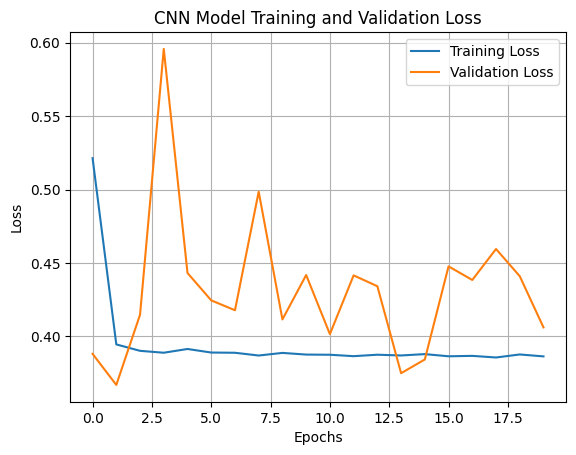

In [33]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CNN Model Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

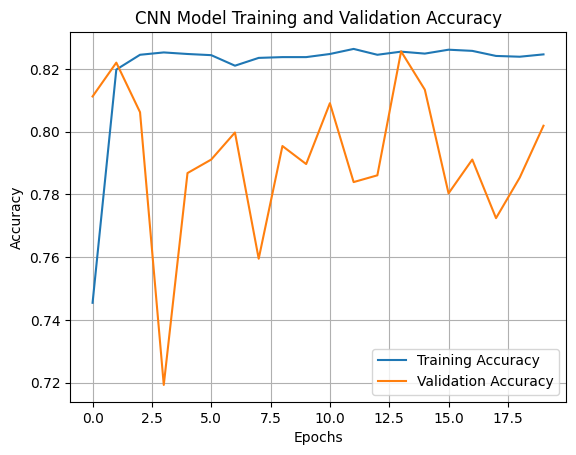

In [34]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('CNN Model Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

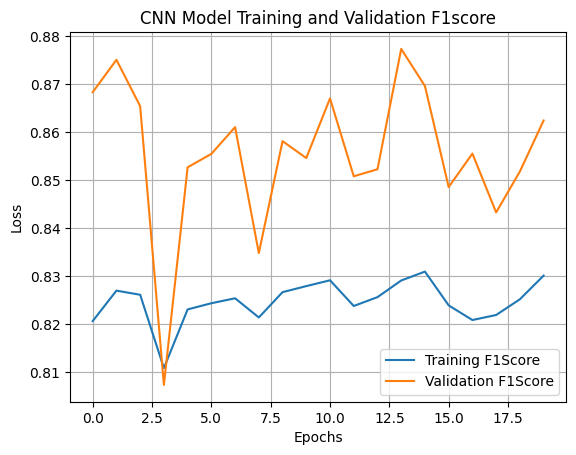

In [35]:
import matplotlib.pyplot as plt

plt.plot(train_metrics_callback.logs.get('f1score'), label='Training F1Score')
plt.plot(metrics_callback.logs.get('f1score'), label='Validation F1Score')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CNN Model Training and Validation F1score')
plt.legend()
plt.grid(True)
plt.show()

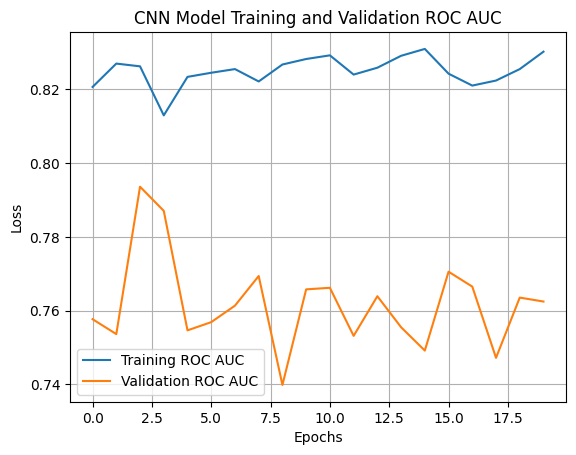

In [36]:
import matplotlib.pyplot as plt

plt.plot(train_metrics_callback.logs.get('roc_auc'), label='Training ROC AUC')
plt.plot(metrics_callback.logs.get('roc_auc'), label='Validation ROC AUC')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CNN Model Training and Validation ROC AUC')
plt.legend()
plt.grid(True)
plt.show()

# Find Optimum Threshold

44/44 [==============================] - 0s 2ms/step


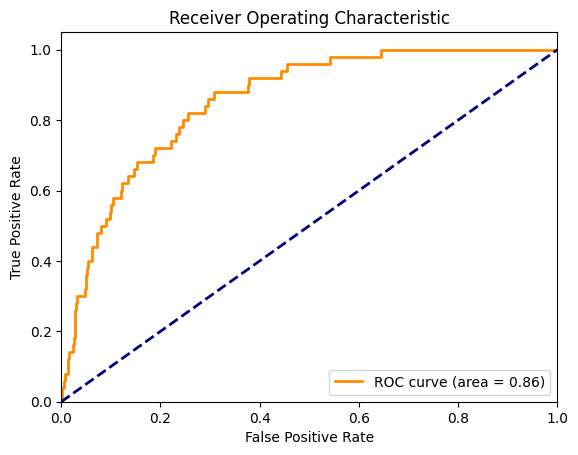

Optimal Threshold: 0.29561781883239746
              precision    recall  f1-score   support

           0       0.99      0.69      0.82      1343
           1       0.10      0.88      0.17        50

    accuracy                           0.70      1393
   macro avg       0.54      0.79      0.49      1393
weighted avg       0.96      0.70      0.79      1393

ROC AUC Score: 0.8550260610573343


In [37]:
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, classification_report
import matplotlib.pyplot as plt

y_pred_prob = model.predict(X_val)[:, 1]

# Assuming y_val are the true labels and y_pred_prob are the predicted probabilities
# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)
roc_auc = roc_auc_score(y_val, y_pred_prob)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Find the optimal threshold
youden_index = tpr - fpr
optimal_idx = np.argmax(youden_index)
optimal_threshold = thresholds[optimal_idx]

print(f'Optimal Threshold: {optimal_threshold}')

# Apply the optimal threshold
y_pred_optimal = (y_pred_prob >= optimal_threshold).astype(int)

# Evaluate performance at the optimal threshold
print(classification_report(y_val, y_pred_optimal))
print(f'ROC AUC Score: {roc_auc}')

In [38]:
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

class MetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data=()):
        super(MetricsCallback, self).__init__()
        self.validation_data = validation_data
        self.logs = {}

    def on_epoch_end(self, epoch, logs={}):
        if not self.validation_data:
            raise RuntimeError("Requires validation_data.")
        if self.logs.get('roc_auc', None) == None:
          self.logs['roc_auc'] = []
        if self.logs.get('f1score', None) == None:
          self.logs['f1score'] = []

        X_val, y_val = self.validation_data
        y_proba = self.model.predict(X_val, verbose=0)
        # y_pred = np.argmax(y_proba, axis=1)

        # Convert one-hot encoded labels to class labels
        y_pred =  [1 if preds[1] >= optimal_threshold else 0 for preds in y_pred]

        # Compute Metrics score
        f1score = f1_score(y_val, y_pred, average='weighted')
        roc_auc = roc_auc_score(y_val, y_pred, average='weighted')

        # Add Metrics score to logs
        self.logs['roc_auc'].append(roc_auc)
        self.logs['f1score'].append(f1score)

In [39]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Evaluate Model

y_proba = model.predict(X_val)
y_pred =  [1 if preds[1] >= optimal_threshold else 0 for preds in y_proba]


accuracy = accuracy_score(y_val, y_pred)
f1score = f1_score(y_val, y_pred, average='weighted')
auc = roc_auc_score(y_val, y_pred, average='weighted')

print("Accuracy: " + str(np.mean(accuracy)*100) + "%")
print("F1 Score: " + str(np.mean(f1score)*100) + "%")
print("AUC: " + str(np.mean(auc)*100) + "%")

44/44 [==============================] - 0s 3ms/step
Accuracy: 69.92103374012922%
F1 Score: 79.30829171708021%
AUC: 78.62397617274758%


In [40]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_val,y_pred)

array([[930, 413],
       [  6,  44]])